In [1]:
import sys
import os
import numpy as np
import re
# import psycopg2 as pg
# import pandas as pd
# import pandas.io.sql as psql
# import getpass
import matplotlib as mpl
# import argparse
# import glob
# import traceback
import hashlib
import math
import collections
import functools
import datetime
from sklearn.externals import joblib
import pickle
import physt

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

# import event_processing_v3
# import event_processing_v4
# import postgresql_v3_event_storage
# import dataset_query_functions_v3

# import tool.acqconv
# from data_analysis_utils import *
# from data_analysis_utils_dataframes import *
# import supervised_classification as supc 
# from utility_funtions import key_vals2val_keys

import event_reading


Welcome to JupyROOT 6.13/02


In [2]:
recreate_plots = True
recreate_pickles = False

In [3]:
files_dir_abspath = '/home/spbproc/SPBDATA_flight'

data_snippets_dir = 'trigger_rate_figures_hw'
os.makedirs(data_snippets_dir, exist_ok=True)
os.makedirs(os.path.join(data_snippets_dir, 'figures'), exist_ok=True)

In [4]:
def filter_func(f,d): 
    r = os.path.splitext(f)[1] == ".root" and "ACQUISITION" in os.path.basename(f) and re.search(r'SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170(42[4-9]|430|5\d+)$',d) is not None
    return r

processed_files = sorted([os.path.join(dp, f) for dp, dn, fn in os.walk(files_dir_abspath) for f in fn if filter_func(f,dp)])

In [5]:
processed_files_subset = processed_files #[60:64]

In [6]:
processed_files_subset

['/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-002.001--LONG.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-003.001--LONG.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-004.001--LONG.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-005.001--LONG.root',
 '/home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-172343-001.001--CHECK.root',
 '/home/spbproc/SPBDATA_f

In [7]:
print('Num processed files', len(processed_files_subset))

Num processed files 1088


In [8]:
len(set([os.path.basename(p) for p in processed_files_subset]))

1088

In [9]:
len(set([os.path.basename(p) for p in processed_files_subset if '20170424' not in p]))

1076

In [10]:
processed_files_hash = hashlib.md5(pickle.dumps(processed_files_subset, protocol=0)).hexdigest()

In [11]:
processed_files_hash

'2feee3b0332fbd7fea6241885d90f2aa'

# Window size by file

In [12]:
def count_trigger_rate_per_file(processed_files_subset, data_snippets_dir, file_name_prefix='', 
                                return_filenames=False, recreate_pickles=False, 
                                one_trg_per_packet=False, packet_size=128):
    
    one_trg_per_packet_str = '_one_trg_per_packet_{:d}'.format(packet_size) if one_trg_per_packet else ''
    
    processed_files_hash = hashlib.md5(pickle.dumps(processed_files_subset, protocol=0)).hexdigest()
    
    if data_snippets_dir is not None:
        trigger_num_per_file_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_trigger_num_per_file.pkl'.format(processed_files_hash, one_trg_per_packet_str))
        trigger_rate_per_file_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_trigger_rate_per_file.pkl'.format(processed_files_hash, one_trg_per_packet_str))
        file_trigger_datetimes_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_file_trigger_datetimes.pkl'.format(processed_files_hash, one_trg_per_packet_str))
        file_trigger_timedelta_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_file_trigger_timedelta.pkl'.format(processed_files_hash, one_trg_per_packet_str))
        file_trigger_p_r_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_file_trigger_p_r.pkl'.format(processed_files_hash, one_trg_per_packet_str))
        file_indices_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_file_indices.pkl'.format(processed_files_hash, one_trg_per_packet_str))
    else:
        recreate_pickles = True
    
    # {allpackets | events}-experiment-mode-date-time-bunch.bunchTot--comment.dat,
    # TODO bunch
    
    filename_type_re = re.compile(r'(\d+)\.(\d+)-+(LONG|CHECK)(-sqz(-dis)?)?\.root$')
    
    filename_datetime_re = re.compile(r'(\d{4})(\d\d)(\d\d)-(\d\d)(\d\d)(\d\d)-(\d+)\.(\d+)-+(LONG|CHECK)(-sqz(-dis)?)?\.root$')
        
    trigger_num_per_file_list = []
    trigger_rate_per_file_list = []
    file_trigger_datetimes_list = []
    file_timedelta_list = []
    file_trigger_p_r_list = []
    file_indices_list = []

    if recreate_pickles or False in [os.path.exists(f) for f in (
            trigger_num_per_file_list_pathname, trigger_rate_per_file_list_pathname, 
            file_trigger_datetimes_list_pathname, file_trigger_timedelta_list_pathname, file_trigger_p_r_list_pathname, 
            file_indices_list_pathname)]:
    
#         print([os.path.exists(f) for f in (
#             trigger_num_per_file_list_pathname, trigger_rate_per_file_list_pathname, 
#             file_trigger_datetimes_list_pathname, file_trigger_timedelta_list_pathname, file_trigger_p_r_list_pathname, 
#             file_indices_list_pathname)])
    
#         return None, None, None, None, None, None
    
        last_p_r = None

        for j, infile in enumerate(sorted(processed_files_subset)):

            print('{:d}/{:d} {}'.format(j+1, len(processed_files_subset), infile))

            filename_type_m = filename_type_re.search(infile)
            if not filename_type_m:
                print(' > SKIPPING')
                continue
            
            if filename_type_m.group(3) == 'LONG':
                acq_timedelta = datetime.timedelta(seconds=120)
            elif filename_type_m.group(3) == 'CHECK':
                acq_timedelta = datetime.timedelta(seconds=40)

            bunch = int(filename_type_m.group(1))
            
            if bunch < 1:
                print(' > SKIPPING (bunch < 1)')
                continue
            
            #####
                
            file_last_frame_gtu_datetime = None
            file_first_frame_gtu_datetime = None
            
            file_last_frame_gtu_datetime__gps_datetime = None
            file_first_frame_gtu_datetime__gps_datetime = None
            
            file_last_frame_gps_datetime = None
            file_first_frame_gps_datetime = None                
                
            ####
                
            trigger_num_per_step = 0

            first_p_r = None
            last_p_r = None

            with event_reading.AcqL1EventReader(
                    infile, None, load_pdm_event_summary=True, parse_pdm_event_summary=False) as aer:

                if aer.tevent_entries <= 0:
                    print(' > no tevent entries')
                
#                 print(' > 1: ', len(aer.exp_tree.tree.run_date))
#                 print(' > 2: ', len(aer.exp_tree.tree.run_date[:-1]))
                
                if len(aer.exp_tree.tree.run_date[:-1]) == 0:
                    print(' > EMPTY exp_tree.run_date')
                    
                    m = filename_datetime_re.search(infile)
                    if m:
                        exp_tree_run_date_datetime = datetime.datetime(
                            year=int(m.group(1)), month=int(m.group(2)), day=int(m.group(3)), 
                            hour=int(m.group(4)), minute=int(m.group(5)), second=int(m.group(6))
                        )
                        print(' >> extracted from filename: ' + str(exp_tree_run_date_datetime))
                        
                    else:
                        print(' >> unable to extract datetime from filename')
                        continue
                    
                else:
                    exp_tree_run_date_datetime = datetime.datetime.strptime(aer.exp_tree.tree.run_date[:-1], '%a %b %d %H:%M:%S %Y')

                exp_tree_run_date_datetime_modified = exp_tree_run_date_datetime + acq_timedelta*(bunch-1)
                    
#                 print(' >> RAW aer.exp_tree.tree.run_date: ' + str(aer.exp_tree.tree.run_date))
    
                last_packet_id = -1
                for i, gtu_pdm_data in enumerate(aer.iter_gtu_pdm_data()):
                    packet_id = i % packet_size
#                     if i==0:
#                         print(' >> (first frame) gtu_pdm_data.gtu_datetime =', gtu_pdm_data.gtu_datetime)
#                         print(' >> (first frame) gtu_pdm_data.gps_datetime =', gtu_pdm_data.gps_datetime)
                    
                    p_r = (aer._tevent_event_p_val.item(), aer._tevent_event_r_val.item())

                    if np.count_nonzero(aer._tevent_event_trig_counts) > 0:
                        if packet_id != last_packet_id or not one_trg_per_packet:
                            trigger_num_per_step += 1
                            last_packet_id = packet_id

                        if first_p_r is None:
                            first_p_r = p_r
                        last_p_r = p_r

                    if file_first_frame_gtu_datetime__gps_datetime is None or file_first_frame_gtu_datetime__gps_datetime > gtu_pdm_data.gps_datetime:
                        file_first_frame_gtu_datetime__gps_datetime = gtu_pdm_data.gps_datetime
                    if file_last_frame_gtu_datetime__gps_datetime is None or file_last_frame_gtu_datetime__gps_datetime < gtu_pdm_data.gps_datetime:
                        file_last_frame_gtu_datetime__gps_datetime = gtu_pdm_data.gps_datetime
    
                    if file_first_frame_gtu_datetime is None or file_first_frame_gtu_datetime > gtu_pdm_data.gtu_datetime:
                        file_first_frame_gtu_datetime = gtu_pdm_data.gtu_datetime
                    if file_last_frame_gtu_datetime is None or file_last_frame_gtu_datetime < gtu_pdm_data.gtu_datetime:
                        file_last_frame_gtu_datetime = gtu_pdm_data.gtu_datetime

                    if file_first_frame_gps_datetime is None or file_first_frame_gps_datetime > gtu_pdm_data.gps_datetime:
                        file_first_frame_gps_datetime = gtu_pdm_data.gps_datetime
                    if file_last_frame_gps_datetime is None or file_last_frame_gps_datetime < gtu_pdm_data.gps_datetime:
                        file_last_frame_gps_datetime = gtu_pdm_data.gps_datetime    
                                               
#                 print(' >> exp_tree_run_date_datetime:         ' + str(exp_tree_run_date_datetime))
#                 print(' >> exp_tree_run_date_datetime + delta: ' + str(exp_tree_run_date_datetime + acq_timedelta))
#                 print(' >> exp_tree_run_date_datetime + delta*(bunch-1): ' + str(exp_tree_run_date_datetime + acq_timedelta*(bunch-1)))
#                 print(' >> exp_tree_run_date_datetime + delta*(bunch): ' + str(exp_tree_run_date_datetime + acq_timedelta*bunch))
                
#                 print(' >> file_first_frame_gtu_datetime =', file_first_frame_gtu_datetime)
#                 print(' >> file_last_frame_gtu_datetime =', file_last_frame_gtu_datetime)
#                 print(' >>>> diff =', file_last_frame_gtu_datetime - file_first_frame_gtu_datetime)
#                 print(' >> file_first_frame_gtu_datetime__gps_datetime =', file_first_frame_gtu_datetime__gps_datetime)
#                 print(' >> file_last_frame_gtu_datetime__gps_datetime =', file_last_frame_gtu_datetime__gps_datetime)
#                 print(' >>>> diff =', file_last_frame_gtu_datetime__gps_datetime - file_first_frame_gtu_datetime__gps_datetime)
#                 print(' >> file_first_frame_gps_datetime =', file_first_frame_gps_datetime)
#                 print(' >> file_last_frame_gps_datetime =', file_last_frame_gps_datetime)
#                 print(' >>>> diff =', file_last_frame_gps_datetime - file_first_frame_gps_datetime)
                
                if first_p_r != last_p_r:
                    print(' > P,R changed in a single file: P={}, R={} -> P={}, R={}'.format(first_p_r, last_p_r))
                    
            if trigger_num_per_step > 0:
                file_trigger_p_r_list.append(first_p_r)
                trigger_num_per_file_list.append(trigger_num_per_step)
                file_trigger_datetimes_list.append(exp_tree_run_date_datetime_modified)
                trigger_rate_per_file_list.append(trigger_num_per_step / acq_timedelta.total_seconds())
                file_timedelta_list.append(acq_timedelta.total_seconds())
                file_indices_list.append(j)

        if data_snippets_dir is not None:
            joblib.dump(file_indices_list, file_indices_list_pathname)
            joblib.dump(trigger_num_per_file_list, trigger_num_per_file_list_pathname)
            joblib.dump(trigger_rate_per_file_list, trigger_rate_per_file_list_pathname)
            joblib.dump(file_trigger_datetimes_list, file_trigger_datetimes_list_pathname)
            joblib.dump(file_trigger_p_r_list, file_trigger_p_r_list_pathname)
            joblib.dump(file_timedelta_list, file_trigger_timedelta_list_pathname)
    
    else:
        trigger_num_per_file_list = joblib.load(trigger_num_per_file_list_pathname)
        trigger_rate_per_file_list = joblib.load(trigger_rate_per_file_list_pathname)
        file_trigger_datetimes_list = joblib.load(file_trigger_datetimes_list_pathname)
        file_trigger_p_r_list = joblib.load(file_trigger_p_r_list_pathname)
        file_timedelta_list = joblib.load(file_trigger_timedelta_list_pathname)
        file_indices_list = joblib.load(file_indices_list_pathname)
        
    ret_list = \
        [file_trigger_datetimes_list, file_timedelta_list, file_trigger_p_r_list, 
         trigger_num_per_file_list, trigger_rate_per_file_list, file_indices_list]
    
    if return_filenames:
        ret_list += [
            trigger_num_per_file_list_pathname,
            trigger_rate_per_file_list_pathname,
            file_trigger_datetimes_list_pathname,
            file_trigger_p_r_list_pathname,
            file_trigger_timedelta_list_pathname,
            file_indices_list_pathname
        ]

    return tuple(ret_list)

In [313]:
mpl_dates = mpl.dates

def vis_trigger_rate(trigger_datetime_steps_list, trigger_rate_steps_list, file_trigger_p_r_list,
                     ax=None, show=True, ylabel='Number of triggered packets per acquisition',
                     marker='o', color=None, alpha=.8, s=10, label=None, scatter_params={}, figsize=(20, 6),
                     padding_fraction=.10, p_r_annotation_color='gray',
                     yscale='log', ylim=None, exact_ylim=False,
                     base_figure_pathname=None, recreate_plots=True,
                    ):

    plt_xlim = (np.min(trigger_datetime_steps_list) - datetime.timedelta(days=1),
                np.max(trigger_datetime_steps_list) + datetime.timedelta(days=1))

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    ax.xaxis.set_major_locator(mpl_dates.DayLocator())
    ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%m/%d'))
    ax.xaxis.set_minor_locator(mpl_dates.HourLocator(byhour=[6, 12, 18]))

    ax.grid(which='major', axis='both', linestyle='--')
    # plt.gca().grid(which='minor', axis='x', linestyle=':', color="#c0c0c0")

    ax.scatter(
        trigger_datetime_steps_list,
        trigger_rate_steps_list,
        s=s, color=color, alpha=alpha, marker=marker, edgecolors='none',
        **scatter_params
    )

    ylim_min = np.min(trigger_rate_steps_list) if ylim is None else ylim[0]
    ylim_max = np.max(trigger_rate_steps_list) if ylim is None else ylim[1]

    # print(ylim_min, ylim_max)

    ylim_max_p_r_padding = ylim_max - padding_fraction / 3
    ylim_max_p_r_text_padding = ylim_max - padding_fraction / 2

    if not exact_ylim:
        if yscale == 'log':
            log10_ylim_max = np.log10(ylim_max)
            log10_ylim_min = np.log10(ylim_min)

            # print(log10_ylim_min, log10_ylim_max)

            ylim_padding = (log10_ylim_max - log10_ylim_min) * padding_fraction

            # print(ylim_padding)

            ylim_min = 10 ** (log10_ylim_min - ylim_padding)
            ylim_max = 10 ** (log10_ylim_max + ylim_padding)

            ylim_max_p_r_padding = 10 ** (log10_ylim_max + ylim_padding / 3)
            ylim_max_p_r_text_padding = 10 ** (log10_ylim_max + ylim_padding / 2)

        else:
            ylim_padding = padding_fraction
            ylim_min = ylim_min - ylim_padding
            ylim_max = ylim_max + ylim_padding
            ylim_max_p_r_padding = ylim_min - ylim_padding / 3
            ylim_max_p_r_text_padding = ylim_max + ylim_padding / 2

    ax.set_yscale(yscale)

    # print(ylim_min, ylim_max)

    ax.set_ylim(ylim_min, ylim_max)

    ax.set_xlim(*plt_xlim)

    # plt.ylim(1e-1, np.max(trigger_num_per_step)+10)
    ax.set_xlabel('Date [UTC]')
    ax.set_ylabel(ylabel)

    if file_trigger_p_r_list is not None:
        v_prev = file_trigger_p_r_list[0]
        v_x_start = trigger_datetime_steps_list[0]
        v_x_last = v_x_start
        if len(file_trigger_p_r_list) > 1 and len(trigger_datetime_steps_list) > 1:
            for i, (v, v_x) in enumerate(zip(file_trigger_p_r_list[1:], trigger_datetime_steps_list[1:])):
                if v != v_prev or i == len(file_trigger_p_r_list) - 2:
                    ax.plot([v_x_start, v_x_last], [ylim_max_p_r_padding] * 2, color=p_r_annotation_color, linewidth=3)
                    ax.text(v_x_start, ylim_max_p_r_text_padding, 'P={} R={}'.format(*v_prev),
                            color=p_r_annotation_color)
                    v_x_start = v_x
                v_prev = v
                v_x_last = v_x

    if base_figure_pathname:
        trigger_rate_scatter_pathname = base_figure_pathname + '_scatter.png'
        if not os.path.exists(trigger_rate_scatter_pathname) or recreate_plots:
            plt.savefig(trigger_rate_scatter_pathname, dpi=150)

    if show:
        plt.show()

In [14]:
file_trigger_datetime_list, file_timedelta_list, file_trigger_p_r_list, trigger_num_per_file_list, file_trigger_rate_list, file_indices_list, \
trigger_num_per_file_list_pathname, trigger_rate_per_file_list_pathname, file_trigger_datetimes_list_pathname, \
file_trigger_p_r_list_pathname, file_trigger_timedelta_list_pathname, file_indices_list_pathname = \
    count_trigger_rate_per_file(processed_files, data_snippets_dir, return_filenames=True)

In [15]:
print('trigger_num_per_file_list_pathname   ', trigger_num_per_file_list_pathname)
print('trigger_rate_per_file_list_pathname  ', trigger_rate_per_file_list_pathname)
print('file_trigger_datetimes_list_pathname ', file_trigger_datetimes_list_pathname)
print('file_trigger_p_r_list_pathname       ', file_trigger_p_r_list_pathname)
print('file_trigger_timedelta_list_pathname ', file_trigger_timedelta_list_pathname)
print('file_indices_list_pathname           ', file_indices_list_pathname)

trigger_num_per_file_list_pathname    trigger_rate_figures_hw/2feee3b0332fbd7fea6241885d90f2aa_trigger_num_per_file.pkl
trigger_rate_per_file_list_pathname   trigger_rate_figures_hw/2feee3b0332fbd7fea6241885d90f2aa_trigger_rate_per_file.pkl
file_trigger_datetimes_list_pathname  trigger_rate_figures_hw/2feee3b0332fbd7fea6241885d90f2aa_file_trigger_datetimes.pkl
file_trigger_p_r_list_pathname        trigger_rate_figures_hw/2feee3b0332fbd7fea6241885d90f2aa_file_trigger_p_r.pkl
file_trigger_timedelta_list_pathname  trigger_rate_figures_hw/2feee3b0332fbd7fea6241885d90f2aa_file_trigger_timedelta.pkl
file_indices_list_pathname            trigger_rate_figures_hw/2feee3b0332fbd7fea6241885d90f2aa_file_indices.pkl


In [16]:
otgpp_file_trigger_datetime_list, otgpp_file_timedelta_list, otgpp_file_trigger_p_r_list, otgpp_trigger_num_per_file_list, otgpp_file_trigger_rate_list, otgpp_file_indices_list, \
otgpp_trigger_num_per_file_list_pathname, otgpp_trigger_rate_per_file_list_pathname, otgpp_file_trigger_datetimes_list_pathname, \
otgpp_file_trigger_p_r_list_pathname, otgpp_file_trigger_timedelta_list_pathname, otgpp_file_indices_list_pathname = \
    count_trigger_rate_per_file(processed_files, data_snippets_dir, return_filenames=True, one_trg_per_packet=True)

In [141]:
# file_trigger_datetime_list, trigger_num_per_file_list, file_trigger_rate_list, file_trigger_p_r_list = \
#     count_trigger_rate_per_file(processed_files[137:138], data_snippets_dir=None)

In [30]:
# backup_lists = file_trigger_datetime_list, file_timedelta_list, file_trigger_p_r_list, trigger_num_per_file_list, file_trigger_rate_list

# file_trigger_datetime_list, file_timedelta_list, file_trigger_p_r_list, trigger_num_per_file_list, file_trigger_rate_list = backup_lists

### Multiple trg per packet

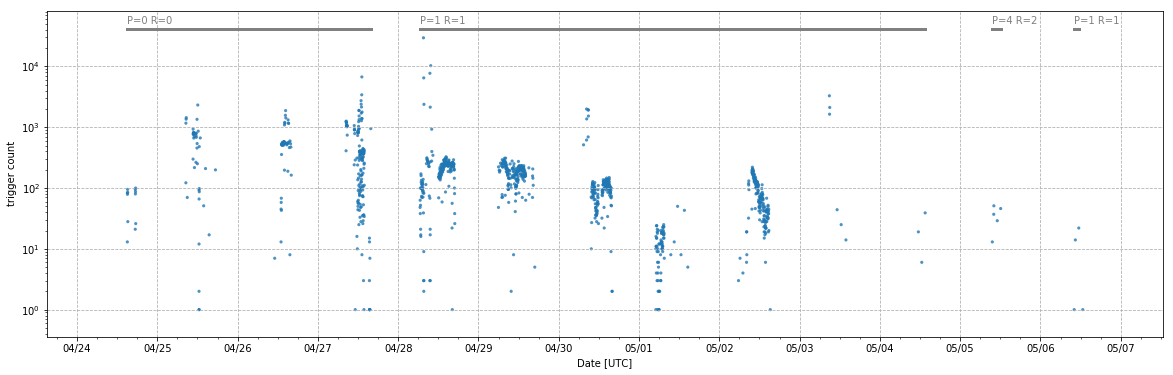

In [17]:
vis_trigger_rate(file_trigger_datetime_list, trigger_num_per_file_list, file_trigger_p_r_list, ylabel="trigger count")

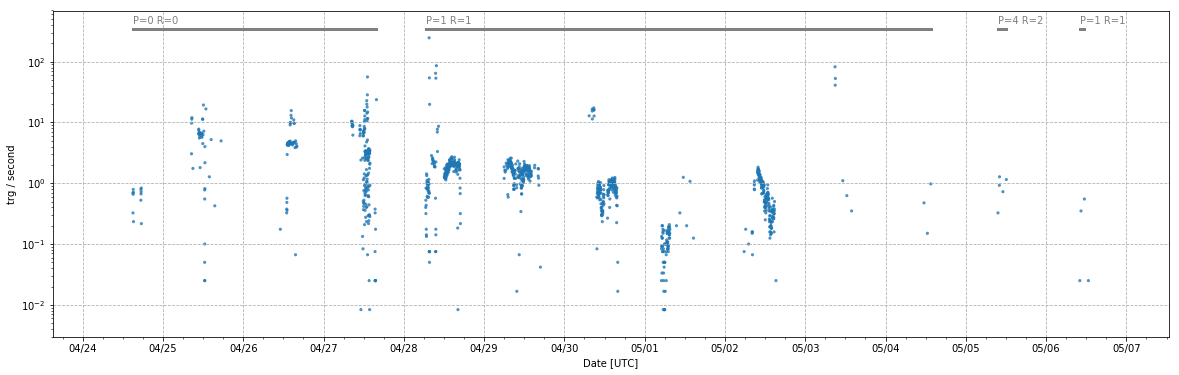

In [18]:
vis_trigger_rate(file_trigger_datetime_list, file_trigger_rate_list, file_trigger_p_r_list)

### Single trg per packet

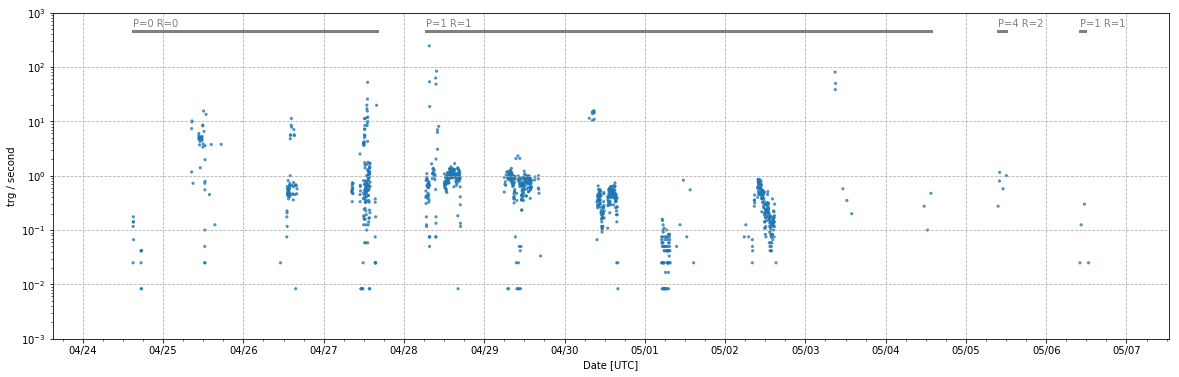

In [19]:
#vis_trigger_rate(otgpp_file_trigger_datetime_list, otgpp_file_trigger_rate_list, otgpp_file_trigger_p_r_list)
vis_trigger_rate(
    otgpp_file_trigger_datetime_list, otgpp_file_trigger_rate_list, otgpp_file_trigger_p_r_list,
    ylim=(10**(-2.5), 10**(2.5))
)

In [315]:
def tigger_datetime_hist(datetime_list, figsize=(20,6), 
                         xlabel='Date [UTC]', ylabel='Number of acquisitions', 
                         xpadding=datetime.timedelta(days=1), 
                         hist_params={}, bin_width_sec=3600,
                         ax=None, show=True):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()
    
    datetime_num_list = mpl_dates.date2num(datetime_list)
    
    ax.xaxis.set_major_locator(mpl_dates.DayLocator())
    ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%m/%d'))
    ax.xaxis.set_minor_locator(mpl_dates.HourLocator(byhour=[6, 12, 18]))
    ax.grid(which='major', axis='both', linestyle='--')
    
    min_datetime = min(datetime_list) - xpadding
    max_datetime = max(datetime_list) + xpadding
    
    hist_bins = \
        int((max_datetime - min_datetime).total_seconds()//bin_width_sec)
        
    ax.set_xlim(min_datetime, max_datetime)
    
    ax.hist(
        datetime_num_list, 
        bins=hist_bins,
        **hist_params
    )
    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    
    if show:
        plt.show()
    
    return fig, ax

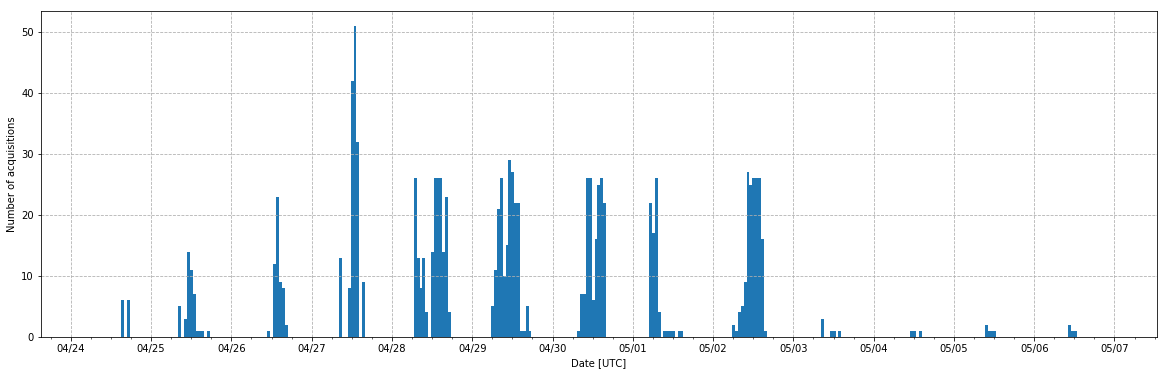

(<Figure size 1440x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb61cc39240>)

In [316]:
tigger_datetime_hist(otgpp_file_trigger_datetime_list)

In [133]:
physt.plotting.common.get_data

<function physt.plotting.common.get_data>

In [137]:
physt.plotting.matplotlib._apply_xy_lims

<function physt.plotting.matplotlib._apply_xy_lims>

In [188]:
def physt_apply_yx_lims(ax, h, data, kwargs):
    """Apply axis limits and scales from kwargs.

    Note: if exponential binning is used, the scale defaults to "log"

    Parameters
    ----------
    data : np.ndarray
        The frequencies or densities or otherwise manipulated data
    kwargs: dict
        yscale : Optional[str]
            If "log", the horizontal axis will use logarithmic scale
        xscale : Optional[str]
            If "log", the vertical axis will use logarithmic scale
        ylim : { "keep", "auto" } or tuple(float)
            "auto" (default) - the axis will fit first and last bin edges
            "keep" - let matlotlib figure this out
            tuple - standard parameter for set_ylim
        xlim : { "keep", "auto" } or tuple(float)
            "auto" (default)
                - the axis will fit first and last bin edges (2D)
                - the axis will exceed a bit the maximum value (1D)
            "keep" - let matlotlib figure this out
            tuple - standard parameter for set_xlim
        invert_y : Optional[bool]
            If True, higher values go down

    See Also
    --------
    plt.Axes.set_ylim, plt.Axes.set_xlim, plt.Axes.set_yscale, plt.Axes.set_xscale
    """
    xlim = kwargs.pop("xlim", "auto")
    ylim = kwargs.pop("ylim", "auto")
    invert_y = kwargs.pop("invert_y", False)
    yscale = xscale = None

    from physt.binnings import ExponentialBinning

    if xlim is not "keep":
        if isinstance(xlim, tuple):
            pass
        elif xlim:
            xlim = ax.get_xlim()
            if h.ndim == 1:
                yscale = kwargs.pop("yscale", "log" if isinstance(h.binning, ExponentialBinning) else None)
                xscale = kwargs.pop("xscale", None)
                if data.size > 0 and data.max() > 0:
                    xlim = (0, max(xlim[1], data.max() +
                                   (data.max() - xlim[0]) * 0.1))
                if xscale == "log":
                    xlim = (abs(data[data > 0].min()) * 0.9, xlim[1] * 1.1)
            elif h.ndim == 2:
                yscale = kwargs.pop("yscale", "log" if isinstance(h.binnings[0], ExponentialBinning) else None)
                xscale = kwargs.pop("xscale", "log" if isinstance(h.binnings[1], ExponentialBinning) else None)
                if h.shape[1] >= 2:
                    xlim = (h.get_bin_left_edges(1)[0],
                            h.get_bin_right_edges(1)[-1])
                    if xscale == "log":
                        if xlim[0] <= 0:
                            raise RuntimeError(
                                "Cannot use logarithmic scale for non-positive bins.")
            else:
                raise RuntimeError("Invalid dimension: {0}".format(h.ndim))

            if invert_y:
                xlim = xlim[::-1]
                # ax.xaxis.tick_top()
                # ax.xaxis.set_label_position('top')
        ax.set_xlim(xlim)

    if ylim is not "keep":
        if isinstance(ylim, tuple):
            pass
        elif ylim:
            ylim = ax.get_ylim()
            if h.shape[0] >= 1:
                if h.ndim == 1:
                    ylim = (h.bin_left_edges[0], h.bin_right_edges[-1])
                elif h.ndim == 2:
                    ylim = (h.get_bin_left_edges(0)[
                            0], h.get_bin_right_edges(0)[-1])
                else:
                    raise RuntimeError(
                        "Invalid dimension: {0}".format(h.ndim))
                if yscale == "log":
                    if ylim[0] <= 0:
                        raise RuntimeError(
                            "Cannot use logarithmic scale for non-positive bins.")
        ax.set_ylim(*ylim)

    if yscale:
        ax.set_yscale(yscale)
    if xscale:
        ax.set_xscale(xscale)

In [166]:
def physt_add_ticks_horizontal(ax, h1, kwargs):
    """Customize ticks for an axis (1D histogram).

    Parameters
    ----------
    ticks: {"center", "edge"}, optional
        Position of the ticks
    tick_handler: Callable[[Histogram1D, float, float], Tuple[List[float], List[str]]]
        ...
    """
    ticks = kwargs.pop("ticks", None)
    tick_handler = kwargs.pop("tick_handler", None)

    if tick_handler:
        if ticks:
            raise ValueError("Cannot specify both tick and tick_handler")
        ticks, labels = tick_handler(h1, *ax.get_ylim())
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels)

    if ticks == "center":
        ax.set_yticks(h1.bin_centers)
    if ticks == "edge":
        ax.set_yticks(h1.bin_left_edges)

In [284]:
def physt_add_labels_horizontal(ax, h, kwargs):
    """Add axis and plot labels.
    
    TODO: Document kwargs
    """
    title = kwargs.pop("title", h.title)
    ylabel = kwargs.pop("ylabel", h.axis_names[0])
    xlabel = kwargs.pop("xlabel", h.axis_names[1] if len(h.axis_names) == 2 else None)
    tight_layout = kwargs.pop("tight_layout", True)
    
    if title:
        ax.set_title(title)
    if ylabel:
        ax.set_xlabel(ylabel)
    if xlabel:
        ax.set_xlabel(xlabel)
    
    if tight_layout:
        ax.get_figure().tight_layout()
    
def physt_add_values_horizontal(ax, h1, data, *, value_format=lambda x: x, **kwargs):
    """Show values next to each bin in a 1D plot.

    Parameters
    ----------
    ax : plt.Axes
    h1 : physt.histogram1d.Histogram1D
    data : array_like
        The values to be displayed
    kwargs : dict
        Parameters to be passed to matplotlib to override standard text params.
    """
    from physt.plotting.common import get_value_format
    value_format = get_value_format(value_format)
    text_kwargs = {"ha": "left", "va": "bottom", "clip_on" : True}
    text_kwargs.update(kwargs)

    for y, x in zip(h1.bin_centers, data):
        ax.text(x, y, str(value_format(y)), **text_kwargs)    
        
def physt_add_stats_box_horizontal(h1, ax, stats):
    """Insert a small legend-like box with statistical information.

    Parameters
    ----------
    stats : "all" | "total" | True
        What info to display

    Note
    ----
    Very basic implementation.
    """

    # place a text box in upper left in axes coords
    if stats in ["all", True]:
        text = "Total: {0}\nMean: {1:.2f}\nStd.dev: {2:.2f}".format(
            h1.total, h1.mean(), h1.std())
    elif stats == "total":
        text = "Total: {0}".format(h1.total)
    else:
        raise ValueError("Invalid stats specification")
        
    ax.text(0.95, 0.95, text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right')

In [290]:
def physt_barh(h1, ax, *, errors=False, **kwargs):
    """Bar plot of 1D histograms."""
    show_stats = kwargs.pop("show_stats", False)
    show_values = kwargs.pop("show_values", False)
    value_format = kwargs.pop("value_format", None)
    density = kwargs.pop("density", False)
    cumulative = kwargs.pop("cumulative", False)
    label = kwargs.pop("label", h1.name)
    lw = kwargs.pop("linewidth", kwargs.pop("lw", 0.5))
    text_kwargs = physt.plotting.common.pop_kwargs_with_prefix("text_", kwargs)

    data = physt.plotting.common.get_data(h1, cumulative=cumulative, density=density)

    if "cmap" in kwargs:
        cmap = physt.plotting.matplotlib._get_cmap(kwargs)
        _, cmap_data = physt.plotting.matplotlib._get_cmap_data(data, kwargs)
        colors = cmap(cmap_data)
    else:
        colors = kwargs.pop("color", None)
        
    physt_apply_yx_lims(ax, h1, data, kwargs)
    physt_add_ticks_horizontal(ax, h1, kwargs)

    if errors:
        err_data = physt.plotting.common.get_err_data(h1, cumulative=cumulative, density=density)
        kwargs["yerr"] = err_data
        if "ecolor" not in kwargs:
            kwargs["ecolor"] = "black"

    physt_add_labels_horizontal(ax, h1, kwargs)
    ax.barh(h1.bin_left_edges, data, h1.bin_widths, align="edge",
           label=label, color=colors, linewidth=lw, **kwargs)

    if show_values:
        physt_add_values_horizontal(ax, h1, data, value_format=value_format, **text_kwargs)
    if show_stats:
        physt_add_stats_box_horizontal(h1, ax, stats=show_stats)

In [291]:
# dir(physt)
# physt.plotting.backends['matplotlib'].types
# physt.plotting.backends['matplotlib'].dims

In [292]:
physt_backends_types = physt.plotting.backends['matplotlib'].types
physt_backends_dims = physt.plotting.backends['matplotlib'].dims
if 'barh' not in physt_backends_types:
    physt_backends_types.append('barh')
if 'barh' not in physt_backends_dims:
    physt_backends_dims['barh'] = (1,)
physt.plotting.matplotlib.barh = physt_barh

In [333]:
def tigger_rate_hist(trigger_rate_steps_list, figsize=(20,6), 
                     xlabel='Number of triggered packets per acquisition', 
                     ylabel='Number of acquisitions',
                     padding_fraction=.10, values_scale='log', values_lim=None, exact_values_lim=False,
                     orientation='vertical', grid=True,
                     num_bins=30, bins_param=None, histogram_args=[], histogram_kwargs={},
                     plot_kwargs={}, ax=None, show=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()
        
#     datetime_num_list = mpl_dates.date2num(datetime_list)
    
#     ax.xaxis.set_major_locator(mpl_dates.DayLocator())
#     ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%m/%d'))
#     ax.xaxis.set_minor_locator(mpl_dates.HourLocator(byhour=[6, 12, 18]))
    if grid:
        ax.grid(which='major', axis='both', linestyle='--')
    
#     min_datetime = min(datetime_list) - xpadding
#     max_datetime = max(datetime_list) + xpadding
    
#     hist_bins = \
#         int((max_datetime - min_datetime).total_seconds()//3600)
    
#     print(hist_bins)
    
#     ax.set_xlim(min_datetime, max_datetime)
    
    min_trigger_rate = np.min(trigger_rate_steps_list)
    max_trigger_rate = np.max(trigger_rate_steps_list)
    
    xlim_min = min_trigger_rate if values_lim is None else values_lim[0]
    xlim_max = max_trigger_rate if values_lim is None else values_lim[1]

    # print(xlim_min, xlim_max)

    xlim_max_p_r_padding = xlim_max - padding_fraction / 3
    xlim_max_p_r_text_padding = xlim_max - padding_fraction / 2

    if not exact_values_lim:
        if values_scale == 'log':
            log10_xlim_max = np.log10(xlim_max)
            log10_xlim_min = np.log10(xlim_min)

            # print(log10_xlim_min, log10_xlim_max)

            xlim_padding = (log10_xlim_max - log10_xlim_min) * padding_fraction

            # print(xlim_padding)

            xlim_min = 10 ** (log10_xlim_min - xlim_padding)
            xlim_max = 10 ** (log10_xlim_max + xlim_padding)

            xlim_max_p_r_padding = 10 ** (log10_xlim_max + xlim_padding / 3)
            xlim_max_p_r_text_padding = 10 ** (log10_xlim_max + xlim_padding / 2)

        else:
            xlim_padding = padding_fraction
            xlim_min = xlim_min - xlim_padding
            xlim_max = xlim_max + xlim_padding
            xlim_max_p_r_padding = xlim_min - xlim_padding / 3
            xlim_max_p_r_text_padding = xlim_max + xlim_padding / 2

    histogram_params = [trigger_rate_steps_list]
    if bins_param is None:
        histogram_params.append('exponential' if values_scale == 'log' else 'human')
    if num_bins is not None:
        histogram_params.append(num_bins)

    histogram_params += histogram_args
    h = physt.histogram(*histogram_params, **histogram_kwargs)
    
    if orientation == 'horizontal':
        h_plot_func = lambda h=h, *kargs, **kwargs: h.plot(*kargs, kind='barh', backend='matplotlib', **kwargs)
        lim_func = ax.set_ylim
        scale_func = ax.set_yscale
        ylabel_func = ax.set_xlabel
        xlabel_func = ax.set_ylabel
    else:
        h_plot_func = h.plot
        lim_func = ax.set_xlim
        scale_func = ax.set_xscale
        xlabel_func = ax.set_xlabel  # intentionally
        ylabel_func = ax.set_ylabel
        
    h_plot_func(ax=ax, **plot_kwargs)
    
    lim_func(xlim_min, xlim_max)
    scale_func(values_scale)

    if xlabel is not None:
        xlabel_func(xlabel)

    if ylabel is not None:
        ylabel_func(ylabel)

    # log-scaled bins
    
#     print(xlim_min, xlim_max)
    
#     bins = np.logspace(np.log(min_trigger_rate), np.log(max_trigger_rate), num_bins)
#     widths = (bins[1:] - bins[:-1])
    
#     # Calculate histogram
#     hist = np.histogram(trigger_rate_steps_list, bins=bins)
#     # normalize by bin width
#     hist_norm = hist[0]/widths
    
#     print(bins[:-1])
#     print(hist_norm)
    
#     ax.plot(bins[:-1], hist_norm)
    
#     ax.bar(bins[:-1], hist_norm, widths, **plot_kwargs)
    
#     ax.hist(
#         trigger_rate_steps_list, 
#         bins=250,
#         **plot_kwargs
#    )

#     n, x, p = plt.hist([datetime.datetime(2018,1,1),  datetime.datetime(2018, 2, 1),
#                  datetime.datetime(2018,3, 1)])
    
    if show:
        plt.show()
        
    return fig, ax

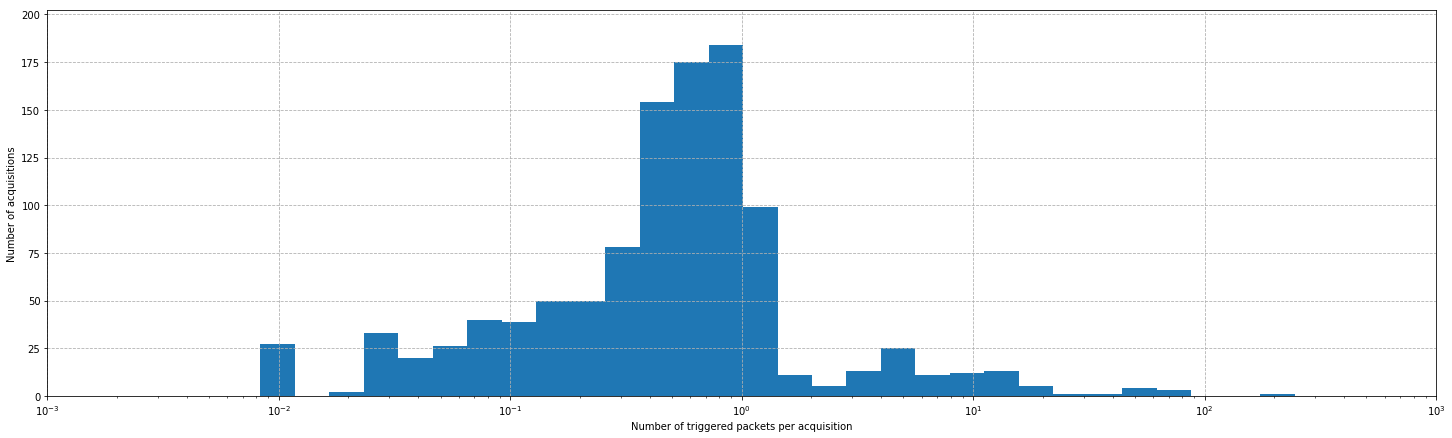

(<Figure size 1440x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb61d97e780>)

In [334]:
tigger_rate_hist(otgpp_file_trigger_rate_list, values_lim=(10**(-2.5), 10**(2.5)))

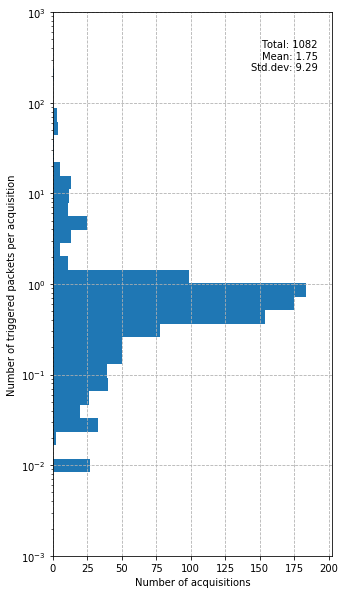

(<Figure size 360x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb6213b5c18>)

In [335]:
plt.close('all')
tigger_rate_hist(otgpp_file_trigger_rate_list, orientation='horizontal', 
                 figsize=(5,10),#plot_kwargs={'color': 'red'}, 
                 values_lim=(10**(-2.5), 10**(2.5)),
                 plot_kwargs={'show_stats':True, 'tight_layout':False})

In [391]:
def vis_trigger_rate_w_distributions(
    file_trigger_datetime_list, file_trigger_rate_list, file_trigger_p_r_list=None,
    ylim=(10**(-2.5), 10**(2.5)), 
    datetime_yscale='log', datetime_bin_width_sec=3600*6,
    vis_trigger_rate_kwargs={}, datetime_hist_kwargs={}, trigger_rate_hist_kwargs={}, 
    ax_scatter=None, ax_histx=None, ax_histy=None,
    figsize=(12,8),
    left=0.1, width=0.8, bottom=0.1, height=0.75, spacing=0.005,
    show=True,
):
    some_ax_none = False
    some_ax_not_none = False
    
    for ax in (ax_scatter, ax_histx, ax_histy):
        if ax is None:
            some_ax_none = True
        if ax is not None:
            some_ax_not_none = True
    
    if some_ax_none and some_ax_not_none:
        raise RuntimeError('Axes need to be either all None or all objects')

    if some_ax_none:
        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom + height + spacing, width, 1 - (bottom + height + spacing)]
        rect_histy = [left + width + spacing, bottom, 1 - (left + width + spacing), height]

        fig = plt.figure(1, figsize=figsize)
        ax_scatter = plt.axes(rect_scatter)
        ax_histx = plt.axes(rect_histx, sharex=ax_scatter)
        ax_histy = plt.axes(rect_histy, sharey=ax_scatter)


    vis_trigger_rate(
        file_trigger_datetime_list, file_trigger_rate_list, file_trigger_p_r_list,
        ylim=ylim,
        ax=ax_scatter, show=False,
        **vis_trigger_rate_kwargs
    )
    
    tigger_datetime_hist(
        file_trigger_datetime_list, bin_width_sec=datetime_bin_width_sec, 
        ax=ax_histx, show=False,
        **datetime_hist_kwargs
    )
    
    if datetime_yscale is not None:
        ax_histx.set_yscale(datetime_yscale)

    # tigger_rate_hist(otgpp_file_trigger_rate_list, values_lim=(10**(-2.5), 10**(2.5)), ax=ax_histx)

    tigger_rate_hist(
        file_trigger_rate_list, orientation='horizontal', 
        values_lim=ax_scatter.get_ylim(),
        ax=ax_histy,
        plot_kwargs={'tight_layout':False},
        show=False,
        **trigger_rate_hist_kwargs
    )

    ax_scatter.tick_params(which='both', axis='both', direction='in', top=True, right=True)
    ax_histx.tick_params(which='both', axis='both', direction='in', labelbottom=False)
    ax_histx.set_xlabel(None)
    ax_histy.tick_params(which='both', axis='both',direction='in', labelleft=False)
    ax_histy.set_ylabel(None)

    if show:
        plt.show()

    # binwidth = 0.25
    # xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    # lim = (int(xymax/binwidth) + 1) * binwidth
    
    return fig, ax_scatter, ax_histx, ax_histy


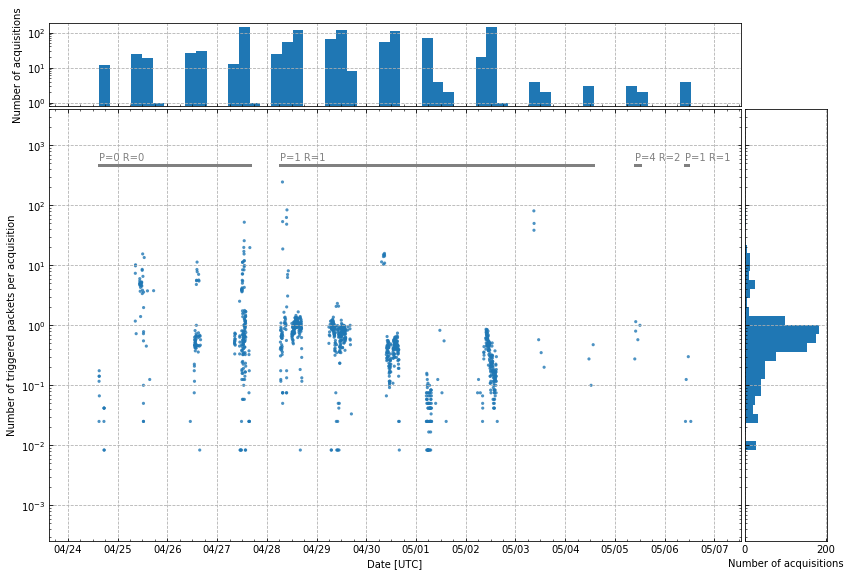

(<Figure size 864x576 with 3 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fb616af2a20>)

In [392]:
vis_trigger_rate_w_distributions(
    otgpp_file_trigger_datetime_list, otgpp_file_trigger_rate_list, otgpp_file_trigger_p_r_list
)

In [218]:
def count_trigger_rate_per_file_test(processed_files_subset,  file_name_prefix='', 
                                return_filenames=False, recreate_pickles=False, 
                                one_trg_per_packet=False, packet_size=128):
    
    one_trg_per_packet_str = '_one_trg_per_packet_{:d}'.format(packet_size) if one_trg_per_packet else ''
    
    processed_files_hash = hashlib.md5(pickle.dumps(processed_files_subset, protocol=0)).hexdigest()

    data_snippets_dir = None
    
    if data_snippets_dir is not None:
        trigger_num_per_file_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_trigger_num_per_file.pkl'.format(processed_files_hash, one_trg_per_packet_str))
        trigger_rate_per_file_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_trigger_rate_per_file.pkl'.format(processed_files_hash, one_trg_per_packet_str))
        file_trigger_datetimes_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_file_trigger_datetimes.pkl'.format(processed_files_hash, one_trg_per_packet_str))
        file_trigger_timedelta_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_file_trigger_timedelta.pkl'.format(processed_files_hash, one_trg_per_packet_str))
        file_trigger_p_r_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_file_trigger_p_r.pkl'.format(processed_files_hash, one_trg_per_packet_str))
        file_indices_list_pathname = \
            os.path.join(data_snippets_dir, file_name_prefix + '{}{}_file_indices.pkl'.format(processed_files_hash, one_trg_per_packet_str))
    else:
        recreate_pickles = True
    
    # {allpackets | events}-experiment-mode-date-time-bunch.bunchTot--comment.dat,
    # TODO bunch
    
    filename_type_re = re.compile(r'(\d+)\.(\d+)-+(LONG|CHECK)(-sqz(-dis)?)?\.root$')
    
    filename_datetime_re = re.compile(r'(\d{4})(\d\d)(\d\d)-(\d\d)(\d\d)(\d\d)-(\d+)\.(\d+)-+(LONG|CHECK)(-sqz(-dis)?)?\.root$')
        
    trigger_num_per_file_list = []
    trigger_rate_per_file_list = []
    file_trigger_datetimes_list = []
    file_timedelta_list = []
    file_trigger_p_r_list = []
    file_indices_list = []

    if recreate_pickles or False in [os.path.exists(f) for f in (
            trigger_num_per_file_list_pathname, trigger_rate_per_file_list_pathname, 
            file_trigger_datetimes_list_pathname, file_trigger_timedelta_list_pathname, file_trigger_p_r_list_pathname, 
            file_indices_list_pathname)]:
    
#         print([os.path.exists(f) for f in (
#             trigger_num_per_file_list_pathname, trigger_rate_per_file_list_pathname, 
#             file_trigger_datetimes_list_pathname, file_trigger_timedelta_list_pathname, file_trigger_p_r_list_pathname, 
#             file_indices_list_pathname)])
    
#         return None, None, None, None, None, None
    
        last_p_r = None

        for j, infile in enumerate(sorted(processed_files_subset)):

            print('{:d}/{:d} {}'.format(j+1, len(processed_files_subset), infile))

            filename_type_m = filename_type_re.search(infile)
            if not filename_type_m:
                print(' > SKIPPING')
                continue
            
            if filename_type_m.group(3) == 'LONG':
                acq_timedelta = datetime.timedelta(seconds=120)
            elif filename_type_m.group(3) == 'CHECK':
                acq_timedelta = datetime.timedelta(seconds=40)

            bunch = int(filename_type_m.group(1))
            
            if bunch < 1:
                print(' > SKIPPING (bunch < 1)')
                continue
            
            #####
                
            file_last_frame_gtu_datetime = None
            file_first_frame_gtu_datetime = None
            
            file_last_frame_gtu_datetime__gps_datetime = None
            file_first_frame_gtu_datetime__gps_datetime = None
            
            file_last_frame_gps_datetime = None
            file_first_frame_gps_datetime = None                
                
            ####
                
            trigger_num_per_step = 0

            first_p_r = None
            last_p_r = None

            with event_reading.AcqL1EventReader(
                    infile, None, load_pdm_event_summary=True, parse_pdm_event_summary=False) as aer:

                if aer.tevent_entries <= 0:
                    print(' > no tevent entries')
                
#                 print(' > 1: ', len(aer.exp_tree.tree.run_date))
#                 print(' > 2: ', len(aer.exp_tree.tree.run_date[:-1]))
                
                if len(aer.exp_tree.tree.run_date[:-1]) == 0:
                    print(' > EMPTY exp_tree.run_date')
                    
                    m = filename_datetime_re.search(infile)
                    if m:
                        exp_tree_run_date_datetime = datetime.datetime(
                            year=int(m.group(1)), month=int(m.group(2)), day=int(m.group(3)), 
                            hour=int(m.group(4)), minute=int(m.group(5)), second=int(m.group(6))
                        )
                        print(' >> extracted from filename: ' + str(exp_tree_run_date_datetime))
                        
                    else:
                        print(' >> unable to extract datetime from filename')
                        continue
                    
                else:
                    exp_tree_run_date_datetime = datetime.datetime.strptime(aer.exp_tree.tree.run_date[:-1], '%a %b %d %H:%M:%S %Y')

                exp_tree_run_date_datetime_modified = exp_tree_run_date_datetime + acq_timedelta*(bunch-1)
                
                
                    
#                 print(' >> RAW aer.exp_tree.tree.run_date: ' + str(aer.exp_tree.tree.run_date))
    
                last_packet_id = -1
                for i, gtu_pdm_data in enumerate(aer.iter_gtu_pdm_data()):
                    packet_id = i % packet_size
#                     if i==0:
#                         print(' >> (first frame) gtu_pdm_data.gtu_datetime =', gtu_pdm_data.gtu_datetime)
#                         print(' >> (first frame) gtu_pdm_data.gps_datetime =', gtu_pdm_data.gps_datetime)
                    
                    p_r = (aer._tevent_event_p_val.item(), aer._tevent_event_r_val.item())

                    if np.count_nonzero(aer._tevent_event_trig_counts) > 0:
                        if packet_id != last_packet_id or not one_trg_per_packet:
                            trigger_num_per_step += 1
                            last_packet_id = packet_id

                        if first_p_r is None:
                            first_p_r = p_r
                        last_p_r = p_r

                    if file_first_frame_gtu_datetime__gps_datetime is None or file_first_frame_gtu_datetime__gps_datetime > gtu_pdm_data.gps_datetime:
                        file_first_frame_gtu_datetime__gps_datetime = gtu_pdm_data.gps_datetime
                    if file_last_frame_gtu_datetime__gps_datetime is None or file_last_frame_gtu_datetime__gps_datetime < gtu_pdm_data.gps_datetime:
                        file_last_frame_gtu_datetime__gps_datetime = gtu_pdm_data.gps_datetime
    
                    if file_first_frame_gtu_datetime is None or file_first_frame_gtu_datetime > gtu_pdm_data.gtu_datetime:
                        file_first_frame_gtu_datetime = gtu_pdm_data.gtu_datetime
                    if file_last_frame_gtu_datetime is None or file_last_frame_gtu_datetime < gtu_pdm_data.gtu_datetime:
                        file_last_frame_gtu_datetime = gtu_pdm_data.gtu_datetime

                    if file_first_frame_gps_datetime is None or file_first_frame_gps_datetime > gtu_pdm_data.gps_datetime:
                        file_first_frame_gps_datetime = gtu_pdm_data.gps_datetime
                    if file_last_frame_gps_datetime is None or file_last_frame_gps_datetime < gtu_pdm_data.gps_datetime:
                        file_last_frame_gps_datetime = gtu_pdm_data.gps_datetime    
                                               
                print(' >> exp_tree_run_date_datetime:         ' + str(exp_tree_run_date_datetime))
                print(' >> exp_tree_run_date_datetime + delta: ' + str(exp_tree_run_date_datetime + acq_timedelta))
                print(' >> exp_tree_run_date_datetime + delta*(bunch-1): ' + str(exp_tree_run_date_datetime + acq_timedelta*(bunch-1)))
                print(' >> exp_tree_run_date_datetime + delta*(bunch): ' + str(exp_tree_run_date_datetime + acq_timedelta*bunch))
                
                print(' >> file_first_frame_gtu_datetime =', file_first_frame_gtu_datetime)
                print(' >> file_last_frame_gtu_datetime =', file_last_frame_gtu_datetime)
                print(' >>>> diff =', file_last_frame_gtu_datetime - file_first_frame_gtu_datetime)
                print(' >> file_first_frame_gtu_datetime__gps_datetime =', file_first_frame_gtu_datetime__gps_datetime)
                print(' >> file_last_frame_gtu_datetime__gps_datetime =', file_last_frame_gtu_datetime__gps_datetime)
                print(' >>>> diff =', file_last_frame_gtu_datetime__gps_datetime - file_first_frame_gtu_datetime__gps_datetime)
                print(' >> file_first_frame_gps_datetime =', file_first_frame_gps_datetime)
                print(' >> file_last_frame_gps_datetime =', file_last_frame_gps_datetime)
                print(' >>>> diff =', file_last_frame_gps_datetime - file_first_frame_gps_datetime)
                
                if first_p_r != last_p_r:
                    print(' > P,R changed in a single file: P={}, R={} -> P={}, R={}'.format(first_p_r, last_p_r))
                    
            if trigger_num_per_step > 0:
                file_trigger_p_r_list.append(first_p_r)
                trigger_num_per_file_list.append(trigger_num_per_step)
                file_trigger_datetimes_list.append(exp_tree_run_date_datetime_modified)
                trigger_rate_per_file_list.append(trigger_num_per_step / acq_timedelta.total_seconds())
                file_timedelta_list.append(acq_timedelta.total_seconds())
                file_indices_list.append(j)

        if data_snippets_dir is not None:
            joblib.dump(file_indices_list, file_indices_list_pathname)
            joblib.dump(trigger_num_per_file_list, trigger_num_per_file_list_pathname)
            joblib.dump(trigger_rate_per_file_list, trigger_rate_per_file_list_pathname)
            joblib.dump(file_trigger_datetimes_list, file_trigger_datetimes_list_pathname)
            joblib.dump(file_trigger_p_r_list, file_trigger_p_r_list_pathname)
            joblib.dump(file_timedelta_list, file_trigger_timedelta_list_pathname)
    
    else:
        trigger_num_per_file_list = joblib.load(trigger_num_per_file_list_pathname)
        trigger_rate_per_file_list = joblib.load(trigger_rate_per_file_list_pathname)
        file_trigger_datetimes_list = joblib.load(file_trigger_datetimes_list_pathname)
        file_trigger_p_r_list = joblib.load(file_trigger_p_r_list_pathname)
        file_timedelta_list = joblib.load(file_trigger_timedelta_list_pathname)
        file_indices_list = joblib.load(file_indices_list_pathname)
        
    ret_list = \
        [file_trigger_datetimes_list, file_timedelta_list, file_trigger_p_r_list, 
         trigger_num_per_file_list, trigger_rate_per_file_list, file_indices_list]
    
    if return_filenames:
        ret_list += [
            trigger_num_per_file_list_pathname,
            trigger_rate_per_file_list_pathname,
            file_trigger_datetimes_list_pathname,
            file_trigger_p_r_list_pathname,
            file_trigger_timedelta_list_pathname,
            file_indices_list_pathname
        ]

    return tuple(ret_list)

In [151]:
otgpp_file_trigger_datetime_list, otgpp_file_timedelta_list, otgpp_file_trigger_p_r_list, otgpp_trigger_num_per_file_list, otgpp_file_trigger_rate_list, otgpp_file_indices_list, \
otgpp_trigger_num_per_file_list_pathname, otgpp_trigger_rate_per_file_list_pathname, otgpp_file_trigger_datetimes_list_pathname, \
otgpp_file_trigger_p_r_list_pathname, otgpp_file_trigger_timedelta_list_pathname, otgpp_file_indices_list_pathname = \
    count_trigger_rate_per_file_test(processed_files, one_trg_per_packet=False)

1/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root
 >> exp_tree_run_date_datetime:         2017-04-24 15:01:43
 >> exp_tree_run_date_datetime + delta: 2017-04-24 15:02:23
 >> exp_tree_run_date_datetime + delta*(bunch-1): 2017-04-24 15:01:43
 >> exp_tree_run_date_datetime + delta*(bunch): 2017-04-24 15:02:23
 >> file_first_frame_gtu_datetime = 2017-04-24 15:01:46.620955
 >> file_last_frame_gtu_datetime = 2017-04-24 15:02:23.322260
 >>>> diff = 0:00:36.701305
 >> file_first_frame_gtu_datetime__gps_datetime = 2017-04-24 15:01:46
 >> file_last_frame_gtu_datetime__gps_datetime = 2017-04-24 15:02:23
 >>>> diff = 0:00:37
 >> file_first_frame_gps_datetime = 2017-04-24 15:01:46
 >> file_last_frame_gps_datetime = 2017-04-24 15:02:23
 >>>> diff = 0:00:37
2/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root
 >> exp_tree

 >> exp_tree_run_date_datetime:         2017-04-24 17:24:27
 >> exp_tree_run_date_datetime + delta: 2017-04-24 17:26:27
 >> exp_tree_run_date_datetime + delta*(bunch-1): 2017-04-24 17:30:27
 >> exp_tree_run_date_datetime + delta*(bunch): 2017-04-24 17:32:27
 >> file_first_frame_gtu_datetime = 2017-04-24 17:36:33.106407
 >> file_last_frame_gtu_datetime = 2017-04-24 17:38:29.677370
 >>>> diff = 0:01:56.570963
 >> file_first_frame_gtu_datetime__gps_datetime = 2017-04-24 17:30:32
 >> file_last_frame_gtu_datetime__gps_datetime = 2017-04-24 17:32:29
 >>>> diff = 0:01:57
 >> file_first_frame_gps_datetime = 2017-04-24 17:30:32
 >> file_last_frame_gps_datetime = 2017-04-24 17:32:29
 >>>> diff = 0:01:57
12/1088 /home/spbproc/SPBDATA_flight/allpackets-SPBEUSO-ACQUISITION-20170424/allpackets-SPBEUSO-ACQUISITION-20170424-172427-005.001--LONG.root
 >> exp_tree_run_date_datetime:         2017-04-24 17:24:27
 >> exp_tree_run_date_datetime + delta: 2017-04-24 17:26:27
 >> exp_tree_run_date_datetime + d

KeyboardInterrupt: 